SECTION 1 — Imports & Path Setup

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np


SECTION 2 — Load Dataset

In [2]:
df = pd.read_csv("../data/raw/diabetes.csv")

df.shape, df.head()

((768, 9),
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0            6      148             72             35        0  33.6   
 1            1       85             66             29        0  26.6   
 2            8      183             64              0        0  23.3   
 3            1       89             66             23       94  28.1   
 4            0      137             40             35      168  43.1   
 
    DiabetesPedigreeFunction  Age  Outcome  
 0                     0.627   50        1  
 1                     0.351   31        0  
 2                     0.672   32        1  
 3                     0.167   21        0  
 4                     2.288   33        1  )

SECTION 3 — Physical Agent (Unit Test)

In [3]:
from agents.physical_agent import PhysicalAgent

physical_agent = PhysicalAgent()
physical_output = physical_agent.preprocess(df)
physical_metadata = physical_agent.get_metadata()

physical_output.head(), physical_metadata


(   BloodPressure   BMI  SkinThickness  BloodPressure_missing  BMI_missing  \
 0           72.0  33.6           35.0                      0            0   
 1           66.0  26.6           29.0                      0            0   
 2           64.0  23.3           29.0                      0            0   
 3           66.0  28.1           23.0                      0            0   
 4           40.0  43.1           35.0                      0            0   
 
    SkinThickness_missing  
 0                      0  
 1                      0  
 2                      1  
 3                      0  
 4                      0  ,
 PhysicalAgentMetadata(features_processed=['BloodPressure', 'BMI', 'SkinThickness'], original_zero_counts={'BloodPressure': 35, 'BMI': 11, 'SkinThickness': 227}, imputation_medians={'BloodPressure': 72.0, 'BMI': 32.3, 'SkinThickness': 29.0}, imputed_counts={'BloodPressure': 35, 'BMI': 11, 'SkinThickness': 227}))

SECTION 4 — Lab Agent (Unit Test)

In [4]:
from agents.lab_agent import LabAgent

lab_agent = LabAgent()
lab_output = lab_agent.preprocess(df)
lab_metadata = lab_agent.get_metadata()

lab_output.head(), lab_metadata


(   Glucose  Insulin  Insulin_missing
 0    148.0    125.0                1
 1     85.0    125.0                1
 2    183.0    125.0                1
 3     89.0     94.0                0
 4    137.0    168.0                0,
 LabAgentMetadata(features_processed=['Glucose', 'Insulin'], original_zero_counts={'Glucose': 5, 'Insulin': 374}, imputation_medians={'Glucose': 117.0, 'Insulin': 125.0}, imputed_counts={'Glucose': 5, 'Insulin': 374}))

SECTION 5 — Demographic Agent (Unit Test)

In [5]:
from agents.demographic_agent import DemographicAgent

demo_agent = DemographicAgent()
demo_output = demo_agent.preprocess(df)
demo_metadata = demo_agent.get_metadata()

demo_output.head(), demo_metadata


(   Age  Pregnancies
 0   50            6
 1   31            1
 2   32            8
 3   21            1
 4   33            0,
 DemographicAgentMetadata(features_processed=['Age', 'Pregnancies'], original_zero_counts={'Age': 0, 'Pregnancies': 111}, imputation_medians={'Age': 29.0, 'Pregnancies': None}, imputed_counts={'Age': 0, 'Pregnancies': 0}))

SECTION 6 — Coordinator Agent (CORE FEATURE FUSION)

In [6]:
from coordinator.coordinator_agent import CoordinatorAgent

coordinator = CoordinatorAgent(
    lab_agent=lab_agent,
    physical_agent=physical_agent,
    demographic_agent=demo_agent
)

final_features = coordinator.run(df)
coord_metadata = coordinator.get_metadata()

final_features.head(), coord_metadata


(   Glucose  Insulin  Insulin_missing  BloodPressure   BMI  SkinThickness  \
 0    148.0    125.0                1           72.0  33.6           35.0   
 1     85.0    125.0                1           66.0  26.6           29.0   
 2    183.0    125.0                1           64.0  23.3           29.0   
 3     89.0     94.0                0           66.0  28.1           23.0   
 4    137.0    168.0                0           40.0  43.1           35.0   
 
    BloodPressure_missing  BMI_missing  SkinThickness_missing  Age  Pregnancies  
 0                      0            0                      0   50            6  
 1                      0            0                      0   31            1  
 2                      0            0                      1   32            8  
 3                      0            0                      0   21            1  
 4                      0            0                      0   33            0  ,
 CoordinatorMetadata(lab_metadata=LabAgentM

SECTION 7 — Prepare Features & Target

In [7]:
X = final_features
y = df["Outcome"]

X.shape, y.shape


((768, 11), (768,))

SECTION 8 — Train / Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((614, 11), (154, 11))

SECTION 9 — Logistic Regression (Baseline Model)

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, solver="liblinear")
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)


SECTION 10 — Baseline Evaluation

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


[[84 16]
 [27 27]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       100
           1       0.63      0.50      0.56        54

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.68       154
weighted avg       0.71      0.72      0.71       154



SECTION 11 — Logistic Regression Coefficients

In [11]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
6,BloodPressure_missing,0.631343
2,Insulin_missing,0.187947
10,Pregnancies,0.103975
4,BMI,0.069917
0,Glucose,0.032008
9,Age,0.007048
1,Insulin,-0.000035
5,SkinThickness,-0.001656
3,BloodPressure,-0.023632
8,SkinThickness_missing,-0.164307


SECTION 12 — XGBoost (FINAL MODEL)

In [12]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    base_score=0.5,
    random_state=42
)

xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,0.5
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


SECTION 13 — XGBoost Evaluation

In [13]:
y_pred_xgb = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


[[82 18]
 [20 34]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.63      0.64        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



SECTION 14 — SHAP Explainability (GLOBAL)

c:\Users\srira\anaconda3\envs\agentxhealth\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 155it [00:33,  4.55it/s]                         


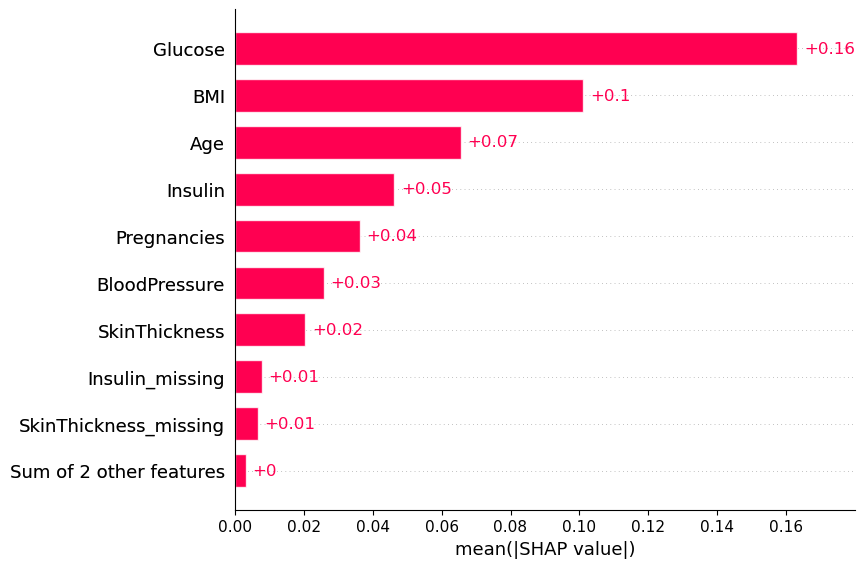

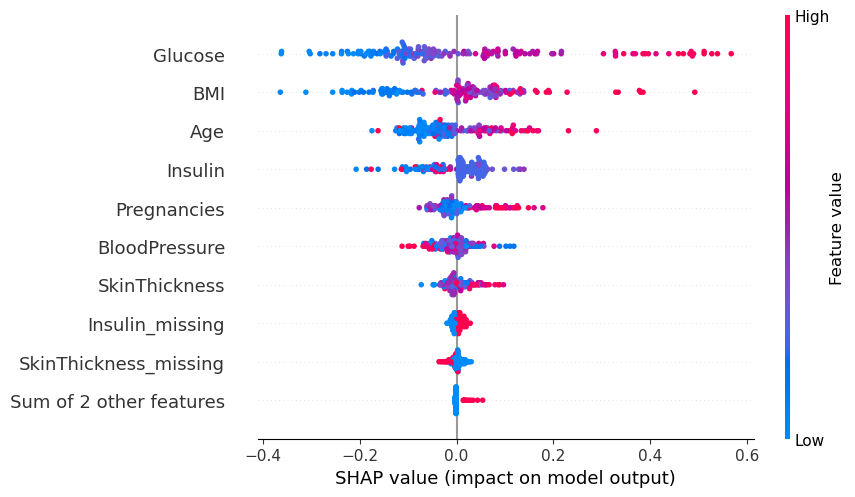

In [14]:
import shap

def model_predict(X):
    return xgb_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(model_predict, X_train)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)


SECTION 15 — Probability Scores

In [15]:
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_proba_xgb[:10]


array([0.792613  , 0.07396303, 0.04886604, 0.34249622, 0.01848247,
       0.16083299, 0.63890845, 0.8430722 , 0.03056289, 0.97200304],
      dtype=float32)

SECTION 16 — Threshold Tuning (Clinical Focus)

In [16]:
from sklearn.metrics import classification_report

thresholds = np.arange(0.2, 0.8, 0.05)
results = []

for t in thresholds:
    y_pred_t = (y_proba_xgb >= t).astype(int)
    report = classification_report(y_test, y_pred_t, output_dict=True)
    
    results.append({
        "threshold": t,
        "recall_diabetic": report["1"]["recall"],
        "precision_diabetic": report["1"]["precision"],
        "f1_diabetic": report["1"]["f1-score"]
    })

threshold_df = pd.DataFrame(results)
threshold_df


,threshold,recall_diabetic,precision_diabetic,f1_diabetic
0,0.20,0.796296,0.573333,0.666667
1,0.25,0.759259,0.594203,0.666667
2,0.30,0.740741,0.606061,0.666667
3,0.35,0.703704,0.603175,0.649573
4,0.40,0.666667,0.610169,0.637168
5,0.45,0.648148,0.625000,0.636364
6,0.50,0.629630,0.653846,0.641509
7,0.55,0.629630,0.708333,0.666667
8,0.60,0.592593,0.727273,0.653061
9,0.65,0.518519,0.717949,0.602151


SECTION 17 — Final Threshold (LOCKED)

In [17]:
FINAL_THRESHOLD = 0.35

y_pred_final = (y_proba_xgb >= FINAL_THRESHOLD).astype(int)

print(classification_report(y_test, y_pred_final))


              precision    recall  f1-score   support

           0       0.82      0.75      0.79       100
           1       0.60      0.70      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



SECTION 18 — Local Explanation (One High-Risk Case)

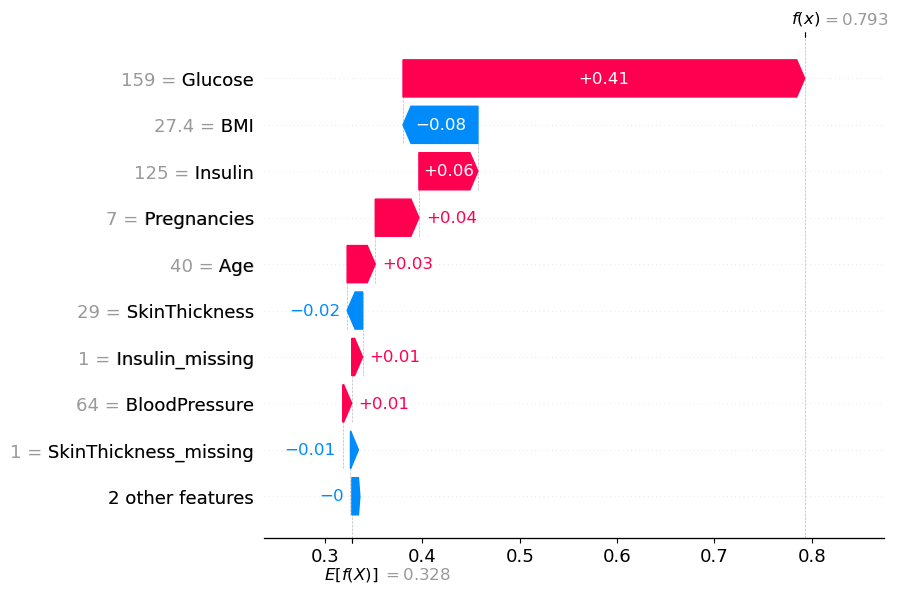

In [18]:
high_risk_idx = np.where(y_proba_xgb >= FINAL_THRESHOLD)[0]
high_risk_idx[:5]

shap.plots.waterfall(shap_values[high_risk_idx[0]])


In [19]:
# Pick the first high-risk patient
patient_idx = high_risk_idx[0]

patient_idx


np.int64(0)

In [20]:
# patient’s feature values

X_test.iloc[patient_idx]


Glucose                  159.0
Insulin                  125.0
Insulin_missing            1.0
BloodPressure             64.0
BMI                       27.4
SkinThickness             29.0
BloodPressure_missing      0.0
BMI_missing                0.0
SkinThickness_missing      1.0
Age                       40.0
Pregnancies                7.0
Name: 44, dtype: float64

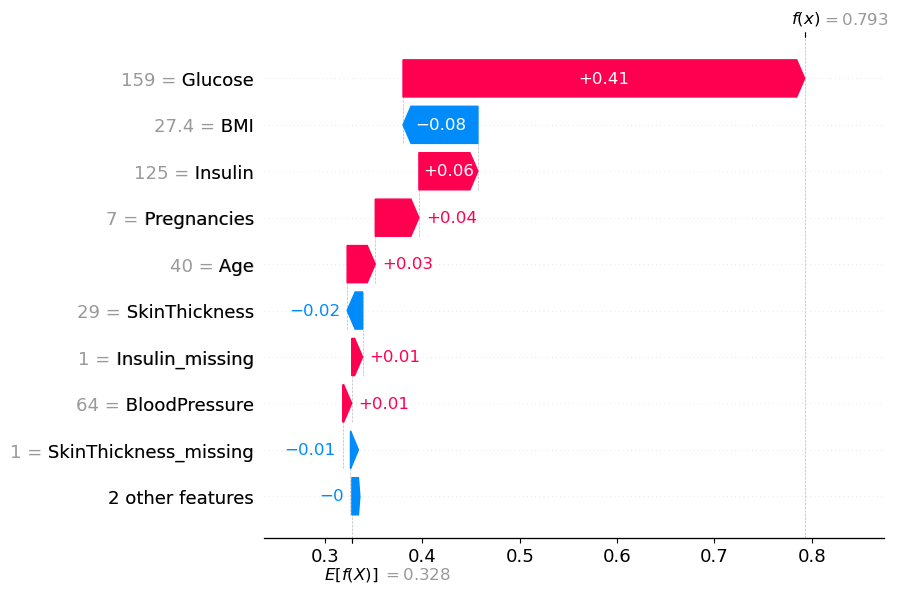

In [21]:
# SHAP Waterfall Plot

shap.plots.waterfall(shap_values[patient_idx])


In [24]:
y_proba_final = y_proba_xgb


In [25]:
# Probability + Decision Together

print("Predicted diabetes probability:", y_proba_final[patient_idx])
print("Risk category:", "High Risk")


Predicted diabetes probability: 0.792613
Risk category: High Risk


In [26]:
final_output = X_test.copy()
final_output["True_Label"] = y_test.values
final_output["Predicted_Probability"] = y_proba_final
final_output["Predicted_Label"] = y_pred_final

final_output.head()


,Glucose,Insulin,Insulin_missing,BloodPressure,BMI,SkinThickness,BloodPressure_missing,BMI_missing,SkinThickness_missing,Age,Pregnancies,True_Label,Predicted_Probability,Predicted_Label
44,159.0,125.0,1,64.0,27.4,29.0,0,0,1,40,7,0,0.792613,1
672,68.0,49.0,0,106.0,35.5,23.0,0,0,0,47,10,0,0.073963,0
700,122.0,200.0,0,76.0,35.9,27.0,0,0,0,26,2,0,0.048866,0
630,114.0,125.0,1,64.0,27.4,29.0,0,0,1,34,7,1,0.342496,0
81,74.0,125.0,1,72.0,32.3,29.0,1,1,1,22,2,0,0.018482,0
